In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_import import etfs_merged
plt.style.use("dark_background")
def leastsquares(A, b):
    import numpy.linalg as npl
    return npl.lstsq(A, b, rcond=None)[0]

In [39]:
negative = etfs_merged.loc[etfs_merged['% change binned'] == 'negative'].loc[:, ["TMAX", "TMIN", "TOTALPRCP"]].values.tolist()
positive = etfs_merged.loc[etfs_merged['% change binned'] == 'positive'].loc[:, ["TMAX", "TMIN", "TOTALPRCP"]].values.tolist()

etfs_data = {
    'positive' : positive, 'negative' : negative }

positive_total = len(positive)
negative_total = len(negative)
total_len = positive_total + negative_total


In [40]:
A = np.zeros((total_len, 3))
A[0:positive_total, :] = etfs_data['positive']
A[positive_total:total_len, :] = etfs_data['negative']
A = np.hstack([np.ones((total_len, 1)), A])

In [41]:
y = np.zeros((total_len,1))
y[0:positive_total] = -1 
y[positive_total:] = 1

In [42]:
x = leastsquares(A,y)
yhat = A @ x
yhat

array([[-0.14080736],
       [-0.05687738],
       [-0.07703017],
       ...,
       [-0.0259681 ],
       [-0.04178802],
       [-0.03739811]])

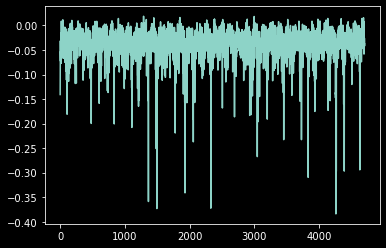

In [43]:
plt.plot(range(total_len), yhat)

In [44]:
y_n = np.zeros((total_len, 1))
y_n[0:positive_total] = 1
y_n[positive_total: total_len] = -1
x_n = leastsquares(A, y_n)
yhat_xn = A @ x_n

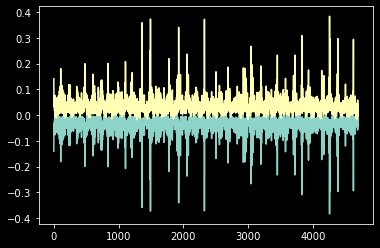

In [45]:
plt.plot(range(total_len),yhat, yhat_xn)

In [46]:
def fhat(row):
    y_positive = row @ x
    y_negative = row @ x_n
    outs = [y_positive, y_negative]
    if max(outs) == y_positive:
        return 'positive'
    else:
        return 'negative'

correct = ['positive'] * positive_total +  ['negative'] * negative_total

yhat_final = np.array([fhat(A[i, :]) for i in range(total_len)])
error_rate_final = sum(yhat_final != np.array(correct))/total_len


In [47]:
print(error_rate_final)

0.519038502446288


In [48]:
def sign(yhat):
    return 2.0 * (yhat > 0) - 1.0

"""Function definitions for Performance metrics, from Table 14.1 and pg.287 in Introduction to Applied Linear Algebra"""

def error_rate(y,yhat,total_len):
    sum_fpfn = 0
    for i in range(total_len):
        if y[i] !=sign(yhat[i]):
            sum_fpfn += 1
    return sum_fpfn/total_len

def true_positive(y,yhat,total_len):
    sum_tp = 0
    sum_p = 0
    for i in range(total_len):
        if y[i] == 1:
            sum_p += 1
            if sign(yhat[i]) == 1:
                sum_tp += 1
    return sum_tp/sum_p
        
def false_positive(y,yhat,total_len):
    sum_fp = 0
    sum_n = 0
    for i in range(total_len):
        if y[i] != 1:
            sum_n += 1
            if sign(yhat[i]) == 1:
                sum_fp += 1
    return sum_fp/sum_n

def true_negative(y,yhat,total_len):
    sum_tn = 0
    sum_n = 0
    for i in range(total_len):
        if y[i] != 1:
            sum_n += 1
            if sign(yhat[i]) !=1:
                sum_tn += 1
    return sum_tn/sum_n
         
def precision(y,yhat,total_len):
    sum_tp = 0
    sum_fp = 0
    for i in range(total_len):
        if y[i] == 1 and sign(yhat[i]) == 1:
            sum_tp += 1
        if y[i] != 1 and sign(yhat[i]) == 1:
            sum_fp += 1
    return sum_tp/(sum_tp + sum_fp)

In [49]:
error_rate(y,yhat,total_len), error_rate(y_n,yhat_xn,total_len)
true_positive(y,yhat,total_len), true_positive(y_n,yhat_xn,total_len)
false_positive(y,yhat,total_len), false_positive(y_n,yhat_xn,total_len)
true_negative(y,yhat,total_len), true_negative(y_n,yhat_xn,total_len)
precision(y,yhat,total_len), precision(y_n,yhat_xn,total_len)

(0.5073529411764706, 0.5193866374589267)

In [54]:
from tabulate import tabulate
data = [['Error Rate', error_rate(y,yhat,total_len), error_rate(y_n,yhat_xn,total_len)], 
        ['True Positive', true_positive(y,yhat,total_len), true_positive(y_n,yhat_xn,total_len)], 
        ['False Positive', false_positive(y,yhat,total_len), false_positive(y_n,yhat_xn,total_len)], 
        ['True Negative', true_negative(y,yhat,total_len), true_negative(y_n,yhat_xn,total_len)],['Precision', precision(y,yhat,total_len), precision(y_n,yhat_xn,total_len)],['Final Error Rate', error_rate_final]]
print (tabulate(data, headers=["Calculated from Positives", "Calculated From Negatives", ]))

                    Calculated from Positives    Calculated From Negatives
----------------  ---------------------------  ---------------------------
Error Rate                          0.480961                     0.480961
True Positive                       0.0304905                    0.972518
False Positive                      0.0274815                    0.96951
True Negative                       0.972518                     0.0304905
Precision                           0.507353                     0.519387
Final Error Rate                    0.519039
